<a href="https://colab.research.google.com/github/Ganesh-Esc/Deep-Learning---Transfer-Learning-Example/blob/main/End_to_End_Example_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **End-to-End Example: Transfer Learning**


## Author

<a href="https://www.linkedin.com/in/ganesh-kommana/" target="_blank">Ganesh Kommana</a>

In this lab, we will walk through an end-to-end example of transfer learning and fine-tuning.


<h1> Is the waste product organic or a recyclable? </h1></s>


You are a data science intern at a waste management service. Your manager has asked you to create a waste classification pipeline that categorizes waste streams based on disposal options: organic or recyclable.

In this lab we're going to train a transfer learning model to perform this image classification task.


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L2/img/transfer_learning.gif" width="600" height="600">


## Objectives

After completing this lab you will be able to:

- __Perform__ pre-processing and image augmentation on ImageGeneratorClass objects in Keras.
- __Implement__ transfer learning in five general steps:
    - obtain pre-trained model,
    - create base model,
    - freeze layers,
    - train new layers on dataset,
    - improve model through fine tuning.
- __Build__ an end-to-end VGG16-based transfer learning model for binary image classification tasks.


### Installing Required Libraries


In [1]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

In [2]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is inc

In [4]:
!pip install skillsnetwork

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.0 MB/s eta 0:00:00


### Importing Required Libraries


In [5]:
import numpy as np
import datetime
import os
import random, shutil
import glob
import skillsnetwork

import warnings
warnings.simplefilter('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib.image import imread

from os import makedirs,listdir
from shutil import copyfile
from random import seed
from random import random
import keras
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn import metrics


sns.set_context('notebook')
sns.set_style('white')

2.20.0


## Background


### What is transfer learning?


Most popular models are difficult to train from scratch as they require huge datasets (like ImageNet), a large number of training iterations, and very heavy computing machinery. The basic features (edges, shapes) learned by early layers in a network are generalizable. While the later layers in an already trained network tend to capture features that are more particular to a specific image classification task.

__Transfer learning__ uses the idea that if we keep the early layers of a pre-trained network, and re-train the later layers on a specific dataset, we might be able to leverage some state of that network on a related task.


A typical transfer learning workflow in Keras looks something like this:
    
1. Initialize base model, and load pre-trained weights (like ImageNet).
2. "Freeze" layers in the base model by setting `training = False`.
3. Define a new model that goes on top of the output of the base model's layers.
4. Train resulting model on your data set.


## Example 1: Create a ML model for distinguishing recyclable and organic waste images


### Dataset


The dataset used in this Lab was found on Kaggle, which is an awesome community for people who enjoy anything related to data science and machine learning. We will be using the Waste Classification Dataset [dataset](https://www.kaggle.com/datasets/techsash/waste-classification-data):


> PROBLEM:
> - Waste management is a big problem in our country. Most of the wastes end up in landfills.

> APPROACH:
> - Segregated into two classes (Organic and recyclable)
> - Automated the process by using IOT and machine learning

> IMPLEMENTATION:
> - Dataset is divided into train data (85%) and test data (15%)
> - Training data - 22,564 images Test data - 2,513 images


* The dataset contains ~25,000 images of recyclable and organic products split into a train and test set.
* Our goal is to train an algorithm on these files and to predict the labels for images in our test set (1 = recyclable, 0 = organic).


Now that we have obtained the necessary context and some insight in today's dataset, we're moving on to the practical part: using transfer learning to classify images. In this task, we will be using Tensorflow, which is a highly used ML library for training neural networks, and Keras, which is an API that makes this process simpler.


We will go through the following steps to create our classification model:


1. Import data directly from Kaggle.
2. Visualize a few random images from the train set.
3. Load images in using the ImageGeneratorClass from Keras.
4. Define model configuration options.
5. Perform some image augmentation for improved model generalizability.
6. Load, compile and train a pre-trained model like VGG-16.
7. Perform inference on the test set.


### Importing Data


This will create a `o-vs-r-split` directory in your environment.


In [6]:
import skillsnetwork
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/datasets/o-vs-r-split.tar.gz",
                           overwrite=True)


  0%|          | 0/8097 [00:00<?, ?it/s]

Saved to '.'


### Define configuration options


It's time to define some model configuration options.


* __img_rows__ and __img_cols__ are used to specify width and height of the images expected by MobileNet.
* __batch size__ is set to 32.
* The __number of epochs__ (that is, iterations) is set to 5, but as we are using Early Stopping, the number of iterations might be lower if early stopping conditions are met before 5 iterations.
* The __number of classes__ is 2.
* We will use 20% of the data for __validation__ purposes.
* We want to be able to see the model output, so we set __verbosity__ to 1, or True.
* The __path__ is a path to the directory with the training data and __path_test__ should contain the test data.
* The __input_shape__ is common for an image: (w, h, d).
* We have two __labels__ in our dataset: organic (O), recyclable (R).
* The __checkpoint_path__ is where ModelCheckpoint will save our model.


In [7]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3) #RGB
labels = ['O', 'R']
seed = 10
checkpoint_path='ORnet.h5'

### Loading Images using ImageGeneratorClass


Transfer learning works best when models are trained on smaller datasets. We are using 10,000 images from the original dataset of 25,000 images. We are setting aside 10% of the set for testing purposes.


The folder structure looks as follows:


```python
o-vs-r-split/
└── train
    ├── O
    └── R
└── test
    ├── O
    └── R
```


#### Image Augmentation


Now we will create ImageDataGenerators used for training, validation, and testing.

Image data generators create batches of tensor image data with real-time data augmentation. They loop over the data in batches and are useful in feeding data to the training process. We specify a 20% validation split.

We will perform a few image augmentation steps. We set __rescale__ to 1./255. This means that each image pixel will be divided by 255 in order to normalize the image. We set the __width_shift_range__ and __height_shift_range__ to 0.1 each, and the __horizontal_flip__ to True.
* The __width_shift_range__ shifts the image horizontally (left or right).
* The __height_shift_range__ shifts the image vertically (up or down).
* The __horizontal_flip__ randomly flip inputs horizontally.


In [8]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

Since it is undesirable to load all of our image data into memory all at once, we make use of the __flow_from_directory__ method. It takes the ImageDataGenerator training/validation sets and flows image batches from a specified folder.

* We set __directory__ to the __path__, specifying the path to our training dataset.
* We specify classes using __labels__ we had defined in the configuration step.
* We apply a __seed__ so our random initializer is generated in the same way each time we perform this step. This allows for direct comparison between experiments.


In [9]:
# use the labels defined before to
# find number of images belonging to each category
train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'training'
)

Found 5810 images belonging to 2 classes.


In [10]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'validation'
)

Found 1452 images belonging to 2 classes.


In [11]:
test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    classes = labels,
    class_mode='binary',
    seed = seed,
    batch_size = batch_size,
    shuffle = True,
    target_size=(img_rows, img_rows)
)

Found 828 images belonging to 2 classes.


There were 5810 images belonging to 2 classes found in the train directory, and 1452 images belonging to the same two classes were found in the validation directory, and 828 images were found in the test set.


Let's look at a few augmented images:


Labels: [np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O')]


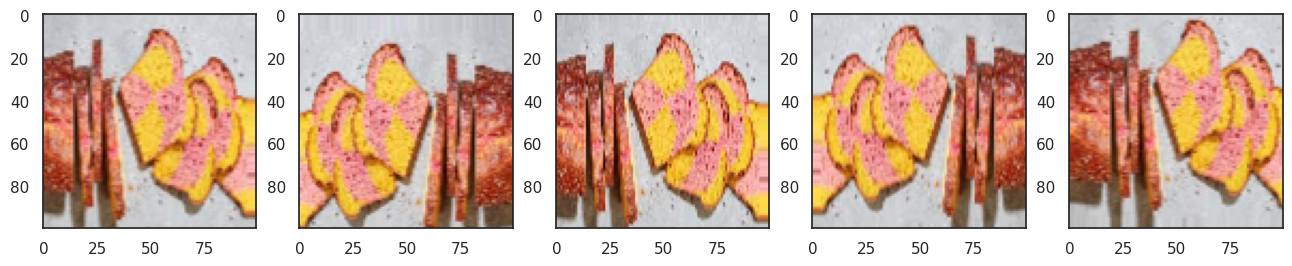

In [12]:
IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[3].split('.')[0].strip() for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]


### Pre-trained Models


Pre-trained models are saved networks that have previously been trained on some large (somewhat related) datasets. They are typically used for a large-scale image-classification task. They can be used as they are or could be customized to a given task using transfer learning. These pre-trained models form the basis of transfer learning.


We can leverage a pre-trained model's weighted layers to extract generic features. In this step we would not update the model's layers weights during training. This helps us utilize the knowledge from a source-domain task.


Fine-tuning, which is a more involved process, involves more than just replacing the final layer. We also try to retrain some of the previous layers.


In computer vision, some popular pre-trained models include: VGG-16, VGG-19, InceptionV3, XCeption, and ResNet-50.


#### VGG-16


Let us load the VGG16 model.

```python
tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_shape=None,
)
```
The default input image size for this model is 224x224.

Further information on arguments can be found in the Keras [documentation](https://keras.io/api/applications/vgg/).

>Note: Each Keras Application expects a specific kind of input preprocessing. For VGG16, call `tf.keras.applications.vgg16.preprocess_input` on your inputs before passing them to the `model.vgg16.preprocess_input` will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

>* __include_top__: whether to include the fully-connected layer at the top of the network.
>* __weights__: one of None (random initialization), 'imagenet' (pre-trained on ImageNet), or the path to the weights file to be loaded.
>* __input_shape__: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3).


First we load the model


In [13]:
from keras.applications import vgg16
input_shape = (150, 150, 3)

vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We flatten the output of a vgg model and assign it to the model ```output```, we then use a Model object ```basemodel``` to group the layers into an object for training and inference .
With the following inputs and outputs  

inputs: ```vgg.input```

outputs: ```tf.keras.layers.Flatten()(output)```


In [14]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

Next, we freeze the basemodel, like the lower layers.


In [15]:
basemodel.trainable = False
for layer in basemodel.layers: layer.trainable = False

Create a new model on top. We add a Dropout layer for regularization, only these layers will change as for the lower layers we set `training=False` when calling the base model.


In [16]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

Let us print the model summary.


In [17]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


### Compile the model


Calling `compile()` freezes the behavior of that model, implying that the trainable attribute values at the time of compilation are preserved.


We use RMSProp as our optimizer with a learning rate of 2e-5, Binary Cross Entropy Loss as our loss function and Accuracy as our primary metric for model evaluation as we have 2 labels in our dataset.


In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])


We use early stopping to avoid over-training the model. An over-trained model overfits the training dataset and has poor performance on unseen test sets. We will also use a exponential step-decay based learning rate scheduler.


In [19]:
from keras.callbacks import LearningRateScheduler
checkpoint_path='O_R_tlearn_image_augm_cnn_vgg16.h5'

# define step decay function
class LossHistory_(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-5
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'loss',
                    patience = 5,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_, keras_callbacks]

### Fit and train the model


In [20]:
extract_feat_model = model.fit(train_generator,
                              steps_per_epoch=10,
                              epochs=5,
                              validation_data=val_generator,
                              validation_steps=10,
                              verbose=1,
                              callbacks = callbacks_list_)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5052 - loss: 0.7446

lr: 9.048374180359596e-06
10/10 ━━━━━━━━━━━━━━━━━━━━ 171s 18s/step - accuracy: 0.5067 - loss: 0.7441 - val_accuracy: 0.5906 - val_loss: 0.6721 - learning_rate: 1.0000e-05
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5371 - loss: 0.6859

lr: 8.18730753077982e-06
10/10 ━━━━━━━━━━━━━━━━━━━━ 202s 22s/step - accuracy: 0.5391 - loss: 0.6860 - val_accuracy: 0.6187 - val_loss: 0.6450 - learning_rate: 9.0484e-06
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5825 - loss: 0.6818

lr: 7.408182206817179e-06
10/10 ━━━━━━━━━━━━━━━━━━━━ 161s 17s/step - accuracy: 0.5833 - loss: 0.6821 - val_accuracy: 0.7000 - val_loss: 0.6058 - learning_rate: 8.1873e-06
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6388 - loss: 0.6503

lr: 6.703200460356394e-06
10/10 ━━━━━━━━━━━━━━━━━━━━ 150s 16s/step - accuracy: 0.6384 - loss: 0.6505 - val_accuracy: 0.7031 - val_loss: 0.5924 - learning_rate: 7.4082e-06
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6233 - loss: 0.6685

lr: 6.065306597126334e-06
10/10 ━━━━━━━━━━━━━━━━━━━━ 159s 17s/step - accuracy: 0.6249 - loss: 0.6661 - val_accuracy: 0.6719 - val_loss: 0.5915 - learning_rate: 6.7032e-06


### Fine-Tuning


Fine-tuning is an optional step in transfer learning, it usually ends up improving the performance of the model. It is easy to overfit the model in this step as we are re-training the entire model. So we use regularization (dropout layers), a lower learning rate, a small number of epochs (training iterations), and early stopping to know when the model has stopped improving and to prevent overfitting.


In order to fine-tune our model, we will use the VGG-16 model object stored in the `basemodel` variable. We will unfreeze convolution blocks 4 and 5 and keep the first 3 blocks frozen. This ensures that the convolution and pooling layers for blocks 4 and 5 are trainable; that is, weights get updated through backpropagation in each training iteration or epoch.


We can find the name of each layer


In [21]:
[layer.name for layer in basemodel.layers]

['input_layer',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten']

we then set ```'block5_conv1'```and ```'block4_conv1' ``` to trainable


In [22]:
basemodel.trainable = True

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Similar to what we did before, we create a new model on top, add a Dropout layer for regularization, and set `training=False` when calling the base model.


In [23]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_image_augm_fine_tune_vgg16.h5'


# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'loss',
                    patience = 5,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_, keras_callbacks]

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator,
                    steps_per_epoch=10,
                    epochs=5,
                    callbacks = callbacks_list_,
                    validation_data=val_generator,
                    validation_steps=10,
                    verbose=1)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5818 - loss: 0.7226 

lr: 9.048374180359596e-06
10/10 ━━━━━━━━━━━━━━━━━━━━ 225s 23s/step - accuracy: 0.5835 - loss: 0.7194 - val_accuracy: 0.6469 - val_loss: 0.6129 - learning_rate: 1.0000e-05
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6322 - loss: 0.6339 

lr: 8.18730753077982e-06
10/10 ━━━━━━━━━━━━━━━━━━━━ 260s 27s/step - accuracy: 0.6307 - loss: 0.6351 - val_accuracy: 0.8188 - val_loss: 0.5211 - learning_rate: 9.0484e-06
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7273 - loss: 0.5525 

lr: 7.408182206817179e-06
10/10 ━━━━━━━━━━━━━━━━━━━━ 264s 27s/step - accuracy: 0.7268 - loss: 0.5533 - val_accuracy: 0.8344 - val_loss: 0.4774 - learning_rate: 8.1873e-06
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7190 - loss: 0.5493 

lr: 6.703200460356394e-06
10/10 ━━━━━━━━━━━━━━━━━━━━ 215s 22s/step - accuracy: 0.7201 - loss: 0.5483 - val_accuracy: 0.8344 - val_loss: 0.4377 - learning_rate: 7.4082e-06
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8442 - loss: 0.4257 

lr: 6.065306597126334e-06
10/10 ━━━━━━━━━━━━━━━━━━━━ 264s 28s/step - accuracy: 0.8431 - loss: 0.4271 - val_accuracy: 0.8313 - val_loss: 0.3733 - learning_rate: 6.7032e-06


The fine tuned model has a validation accuracy higher than the previous transfer learning model.


### Evaluate both models on test data


Load saved models:


In [24]:
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_image_augm_cnn_vgg16.h5')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_image_augm_fine_tune_vgg16.h5')

Load test images:


In [25]:
from sklearn.utils import shuffle


IMG_DIM = (150, 150)

# Read in all O and R test images file paths. Shuffle and select 50 random test images.
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O + test_files_R
test_files = shuffle(test_files)[0:50]

# Extract label from file path
test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[3].split('.')[0].strip() for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

In [26]:
class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

In [27]:
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

In [28]:
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

In [29]:
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))

Extract Features Model
              precision    recall  f1-score   support

           O       0.59      0.92      0.72        25
           R       0.82      0.36      0.50        25

    accuracy                           0.64        50
   macro avg       0.70      0.64      0.61        50
weighted avg       0.70      0.64      0.61        50

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.92      0.92      0.92        25
           R       0.92      0.92      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



#### Custom image: is your waste organic or a recyclable?


['O']

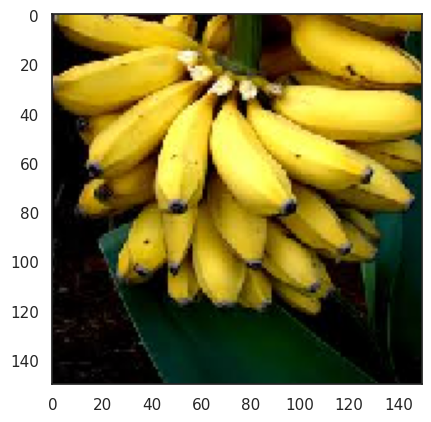

In [30]:
custom_im = test_imgs_scaled[2]
plt.imshow(custom_im)

num2class_lt(extract_feat_model.predict(custom_im.reshape((1,
                                                           test_imgs_scaled.shape[1],
                                                           test_imgs_scaled.shape[2],
                                                           test_imgs_scaled.shape[3])), verbose=0))

['R']

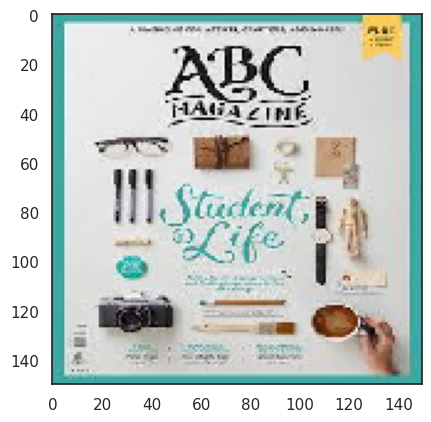

In [31]:
custom_im = test_imgs_scaled[3]
plt.imshow(custom_im)

num2class_lt(extract_feat_model.predict(custom_im.reshape((1,
                                                           test_imgs_scaled.shape[1],
                                                           test_imgs_scaled.shape[2],
                                                           test_imgs_scaled.shape[3])), verbose=0))

Now we are all set to see if our waste product is an organic or a recyclable.


## Example 2: Use Transfer Learning for identifying Stop Signs

Other than VGG-16, there are many state-of-the-art CNN architectures we could explore, such as **InceptionNet, MobileNet, ResNet, Xception**, and so on. There are more than two dozen pre-trained models available from Keras that we could use directly for transfer learning. In this example, we will implement some of them for distinguishing stop signs.

The stop sign datasets will be downloaded using the following cells. Compared to a typical dataset of images, the stop sign dataset is relatively small as it only contains around 200 training images and 8 test images. This is when transfer learning should come to rescue, because training models from scratch would require a lot of data, otherwise you will likely overfit your model.


### Loading images


Uncomment the following cell to download the data files and unzip them.


In [32]:
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/dataset/stop.zip",
                           overwrite=True)
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/dataset/not_stop.zip",
                           overwrite=True)
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/dataset/test_set_stop_not_stop.zip",
                           overwrite=True)

  0%|          | 0/197 [00:00<?, ?it/s]

Saved to '.'


  0%|          | 0/203 [00:00<?, ?it/s]

Saved to '.'


  0%|          | 0/19 [00:00<?, ?it/s]

Saved to '.'


#### Creating image directories

We will rearange the image directories as follows:

```python
signs/
└── train
    ├── stop
    └── not_stop
└── test
    ├── stop
    └── not_stop
```

We will have a train and a test directory, and each contains images that have stop signs and those that don't. This setup of directories will be handy when we use the `flow_from_directory` function later to build data generators.


In [33]:
dataset_home = 'signs/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['stop/', 'not_stop/']
    for labeldir in labeldirs:
        newdir = dataset_home + subdir + labeldir
        makedirs(newdir, exist_ok = True)

#### Moving images

Let's move the images according to the map above.


In [34]:
for file in listdir("stop"):
    if file != '.DS_Store':
        shutil.copyfile(f"stop/{file}", f"signs/train/stop/{file}")

for file in listdir("not_stop"):
    if file != '.DS_Store':
        shutil.copyfile(f"not_stop/{file}", f"signs/train/not_stop/{file}")

test_path = "test_set_stop_not_stop/"
for file in listdir(test_path):
    if file.startswith("stop"):
        shutil.copyfile(test_path+file, f"signs/test/stop/{file}")
    elif file.startswith("not_stop"):
        shutil.copyfile(test_path+file, f"signs/test/not_stop/{file}")


#### Displaying raw images

Use the following code to display the first five images in the train set that have stop signs and the first five images that don't have stop signs.


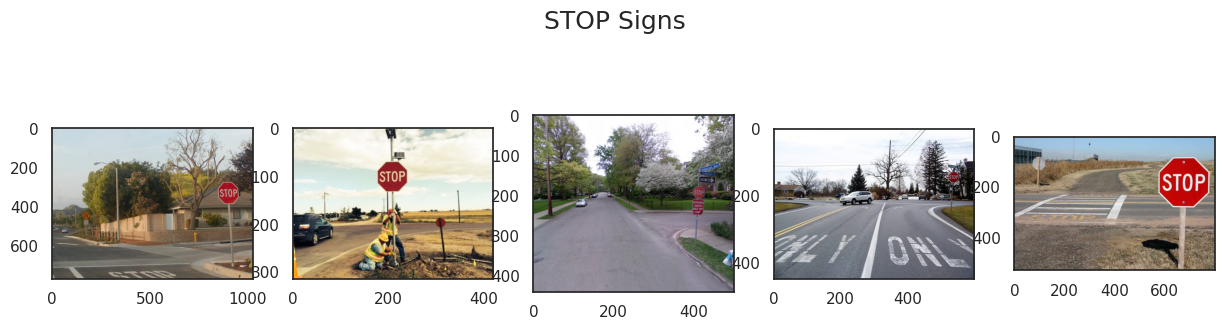

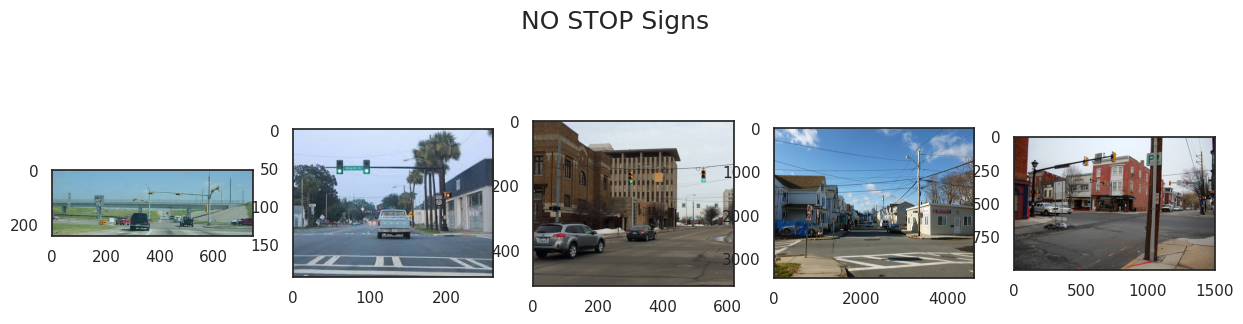

In [35]:
train_stop = glob.glob('./signs/train/stop/*')
train_not_stop = glob.glob('./signs/train/not_stop/*')

fig1, ax1 = plt.subplots(1,5,figsize=(15,4))
fig1.suptitle("STOP Signs", fontsize=18)
l1 = [ax1[i].imshow(imread(train_stop[i])) for i in range(5)]

fig2, ax2 = plt.subplots(1,5,figsize=(15,4))
fig2.suptitle("NO STOP Signs", fontsize=18)
l2 = [ax2[i].imshow(imread(train_not_stop[i])) for i in range(5)]


#### Building image data generators


Same as what we did for the waste data, we will build image data generators that perform real-time image augmentation while returning batches of image data. We will apply image augmentation on the training data only. We use a validation split of 0.2 and a batch size of 30.


In [36]:
path = "signs/train/"
labels = ['stop', 'not_stop']
seed = 123
batch_size = 30
target_size = (112,112)

In [37]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                  rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

val_datagen = ImageDataGenerator(validation_split=0.2,
                                  rescale=1./255.)


In [38]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=target_size,
    subset = 'training'
)

val_generator = val_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=target_size,
    subset = 'validation'
)

Found 158 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


In [39]:
print(train_generator.class_indices)

prob2class = lambda x: 'Stop' if x < 0.5 else 'Not Stop'

{'stop': 0, 'not_stop': 1}


For our test images, we convert them into numpy arrays with pixel values scaled to 0-1. The test data will not be seen by the model during training or validation, but they will be used to evaluate the predictive power of our model at the end.


In [40]:
test_files = glob.glob('signs/test/stop/*.jpeg') + glob.glob('signs/test/not_stop/*.jpeg')
test_files = shuffle(test_files)

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=target_size)) for img in test_files]
test_imgs = np.array(test_imgs).astype('int')

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

### Defining a helper function for building, compiling, and fitting CNNs


In [41]:
def build_compile_fit(basemodel):

    # flatten the output of the base model
    x = Flatten()(basemodel.output)
    # add a fully connected layer
    x = Dense(1024, activation='relu')(x)
    # add dropout layer for regularization
    x = Dropout(0.2)(x)
    # add final layer for classification
    x = Dense(1, activation='sigmoid')(x)

    model = Model(basemodel.input, x)
    model.compile(optimizer = optimizers.RMSprop(learning_rate=0.0001),
                                                       loss='binary_crossentropy',
                                                       metrics=['accuracy'])
    callbacks = [EarlyStopping(monitor = 'loss',
                    patience = 5,
                    mode = 'min',
                    min_delta=0.01)]

    model.fit(train_generator,
              validation_data = val_generator,
              steps_per_epoch=5, # num of batches in one epoch
              epochs=10,
              callbacks=callbacks)

    return model

### Pre-trained Model 1: Inception-v3


**Inception-v3** is a successor to Inception-v1 with 24 million parameters and ran 48 layers deep.

Instead of focusing on increasing the depth of the network, InceptionNet focuses on increasing the width and depth of the model simultaneously to attain better accuracy, while keeping the computing resources constant.

It focuses on **parallel processing** and extraction of various feature maps concurrently using **Inception modules**, which are collections of convolutions with different filter sizes and pooling operations. The following is an illustration of the inception module in inception-v1 architecture:

<center>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L2/img/Inception_v1_module.png"></center>

Picture credits to [Wichai Puarungroj](https://www.researchgate.net/profile/Wichai-Puarungroj-2)

The inception architecture was refined in various ways, specifically for inception-v3, the following improvements are incorporated to achieve less expensive and still efficient networks:

- Factorization Into Smaller Convolutions
- Factorization Into Asymmetric Convolutions
- Auxiliary Classifier used as regularizer
- Efficient Grid Size Reduction

You can read more about the different versions of InceptionNet [here](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202)


Let's import the pre-trained Inception-v3 architecture from keras applications for our transfer learning task:


In [42]:
from keras.applications.inception_v3 import InceptionV3

# initialize the base model
basemodel = InceptionV3(input_shape=(112,112,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

# call the build_compile_fit function to complete model training
inception_v3 = build_compile_fit(basemodel)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.5286 - loss: 4.0027 - val_accuracy: 0.7692 - val_loss: 0.6072
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - accuracy: 0.5667 - loss: 0.8745 - val_accuracy: 0.4872 - val_loss: 2.0779
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5832 - loss: 1.6577 - val_accuracy: 0.7179 - val_loss: 0.8350
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - accuracy: 0.7667 - loss: 0.7592 - val_accuracy: 0.8205 - val_loss: 0.4883
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7227 - loss: 0.5893 - val_accuracy: 0.6667 - val_loss: 0.6138
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step - accuracy: 0.8667 - loss: 0.3139 - val_accuracy: 0.8462 - val_loss: 0.4342
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6799 - loss: 0.7748 - val_accuracy: 0.8462 - val_loss: 0.5799
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - accuracy: 0.7667 - loss: 

The pre-trained part of our **inception_v3** model utilizes the weights obtained from the imagenet dataset training. Only the layers that we added are trained on the stop sign's data.

Let's now display the test images along with their class labels predicted by the fitted **inception_v3**:


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


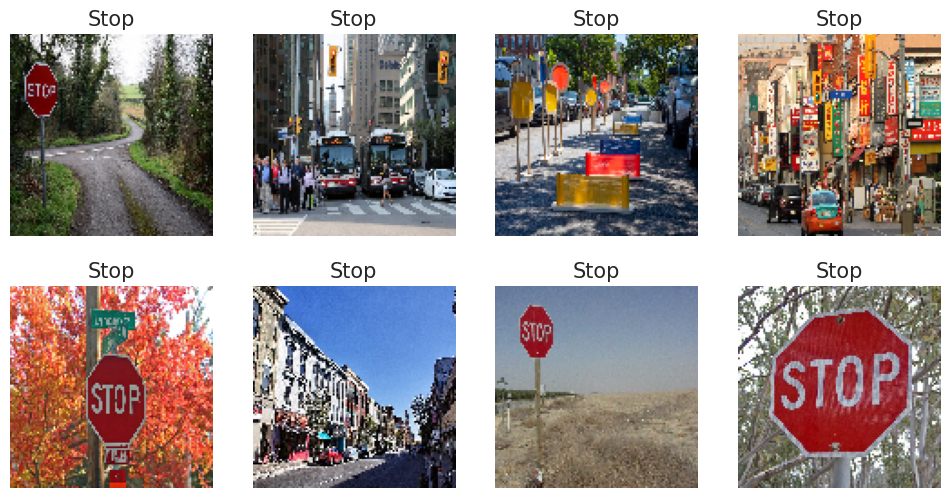

In [43]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(ax.flat):
    ax.imshow(test_imgs[i])
    pred_class = prob2class(inception_v3.predict(test_imgs_scaled[i].reshape(1, 112, 112,3)))

    # print the predicted class label as the title of the image
    ax.set_title(pred_class, fontsize=15)
    ax.axis("off")

### Pre-trained Model 2: MobileNet


**MobileNets** are very efficient and small deep learning architectures specially designed for mobile devices.

It uses of a new kind of convolution layer, known as **Depthwise Separable convolution**. The main difference between a 2D convolution and a Depthwise convolution is that the former is performed over multiple input channels by doing a weighted sum of the input pixels with the filter, whereas the latter is performed separately over each channel.

For example, if the input image has three channels, then the output of depthwise separable convolution will also have three channels. The next step is **Pointwise convolution**, which is similar to a regular convolution with a $1\times1$ filter. By doing so, we can again merge the three channels from depthwise separable convolution into one to create new features.


Let's import the pre-trained MobileNet architecture from keras applications for our transfer learning task:


In [44]:
from keras.applications.mobilenet import MobileNet

# initialize the base model
basemodel = MobileNet(input_shape=(112,112,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

# call the build_compile_fit function to complete model training
mobile_net = build_compile_fit(basemodel)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6329 - loss: 2.7912 - val_accuracy: 0.4872 - val_loss: 5.6967
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.7333 - loss: 1.6159 - val_accuracy: 0.5385 - val_loss: 1.5471
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7406 - loss: 0.9660 - val_accuracy: 0.5128 - val_loss: 3.3787
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step - accuracy: 0.6667 - loss: 0.7017 - val_accuracy: 0.7949 - val_loss: 0.5469
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7624 - loss: 0.9434 - val_accuracy: 0.7436 - val_loss: 0.5660
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.9333 - loss: 0.1117 - val_accuracy: 0.8974 - val_loss: 0.3328
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8857 - loss: 0.3451 - val_accuracy: 0.8974 - val_loss: 0.3264
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.8000 - loss:

Let's display the test images along with the their class labels predicted by the fitted **mobile_net**:


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


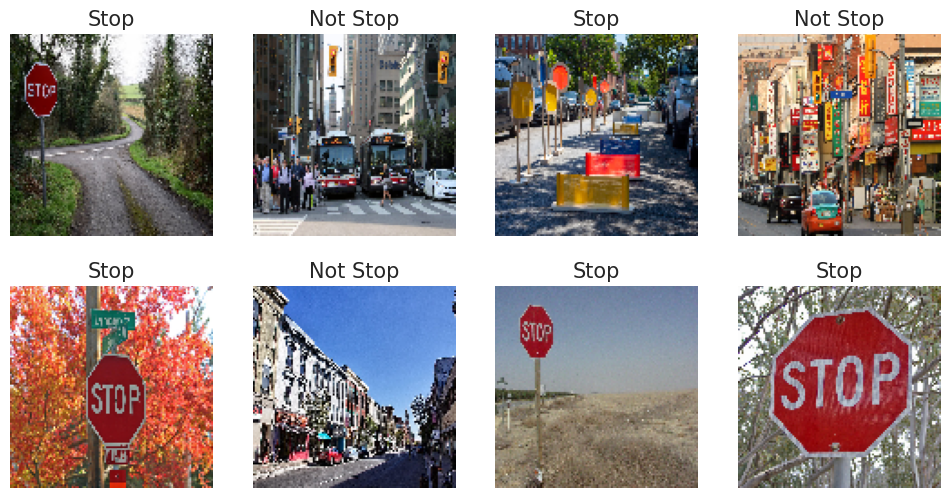

In [45]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(ax.flat):
    ax.imshow(test_imgs[i])
    pred_class = prob2class(mobile_net.predict(test_imgs_scaled[i].reshape(1, 112, 112,3)))

    # print the predicted class label as the title of the image
    ax.set_title(pred_class, fontsize=15)
    ax.axis("off")

### Pre-trained Model 3: ResNet-50


**ResNet** features special skip connections which add the output from an earlier layer directly to a later layer and heavy use of batch normalization. It allows us to design deep CNNs without compromising the model’s convergence and accuracy. The basic building blocks for ResNets are the convolution and identity blocks.

Essentially, ResNet uses the network layers to fit a residual mapping $F(x) + x$, instead of trying to learn the desired underlying mapping $H(x)$ directly with stacked layers.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L2/img/resnet.png" width="30%"></center>

The formulation of $F(x) + x$ can be realized by the feedforward neural networks with **shortcut connections**. Shortcut connections add the output from the previous layer directly to the output of the current layer, which can be seen as **identity mapping**.

By doing so, the network overcomes the vanishing gradient problem because now the gradient signals could travel back to early layers through this shortcut.


Similarly, let's import the pre-trained ResNet-50 architecture from keras applications.


In [46]:
from keras.applications import ResNet50

# initialize the base model
basemodel = ResNet50(input_shape=(112,112,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

# call the build_compile_fit function to complete model training
resnet_50 = build_compile_fit(basemodel)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.4964 - loss: 4.0256 - val_accuracy: 0.4872 - val_loss: 1.1834
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 731ms/step - accuracy: 0.4667 - loss: 1.2230 - val_accuracy: 0.5128 - val_loss: 1.8760
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.4048 - loss: 1.8401 - val_accuracy: 0.4872 - val_loss: 1.3382
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 721ms/step - accuracy: 0.5667 - loss: 1.2604 - val_accuracy: 0.5128 - val_loss: 0.8807
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4761 - loss: 0.8804 - val_accuracy: 0.3846 - val_loss: 0.7135
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 770ms/step - accuracy: 0.5000 - loss: 0.7448 - val_accuracy: 0.5128 - val_loss: 0.9343
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4870 - loss: 0.9817 - val_accuracy: 0.4872 - val_loss: 0.8072
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 706ms/step - accuracy: 0.6000 - loss

Let's display the test images along with their class labels predicted by **resnet_50**:


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


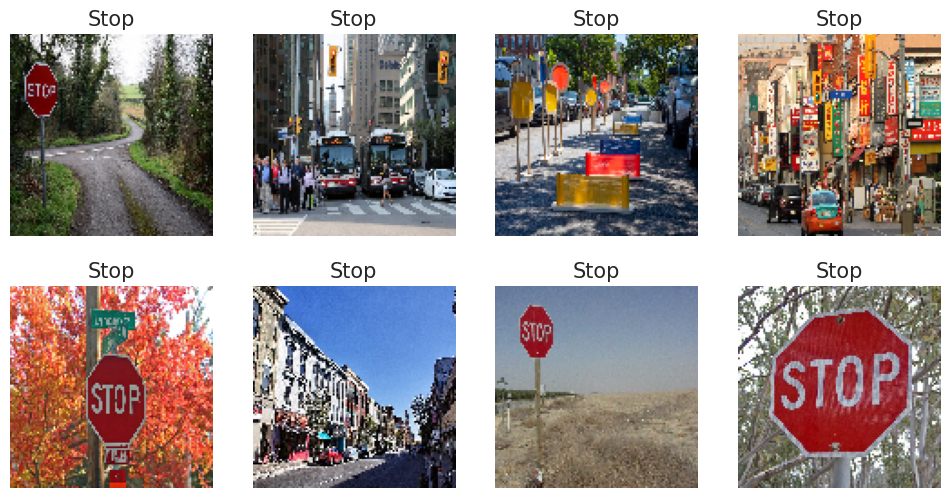

In [47]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(ax.flat):
    ax.imshow(test_imgs[i])
    pred_class = prob2class(resnet_50.predict(test_imgs_scaled[i].reshape(1, 112, 112,3)))

    # print the predicted class label as the title of the image
    ax.set_title(pred_class, fontsize=15)
    ax.axis("off")